In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import seaborn as sn  # for heatmaps
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
transform = transforms.ToTensor()

train_data = datasets.CIFAR10(root='../Data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='../Data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [17]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [18]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [19]:
#creating dataloader
torch.manual_seed(101)
train_loader = DataLoader(train_data,batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [20]:
#Defining strings for labels
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

In [21]:
#viewing a batch of images
for images,labels in train_loader:
  break

# Print the labels
print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

Label: [1 5 8 1 6 1 6 3 7 9]
Class:    car   dog  ship   car  frog   car  frog   cat horse truck


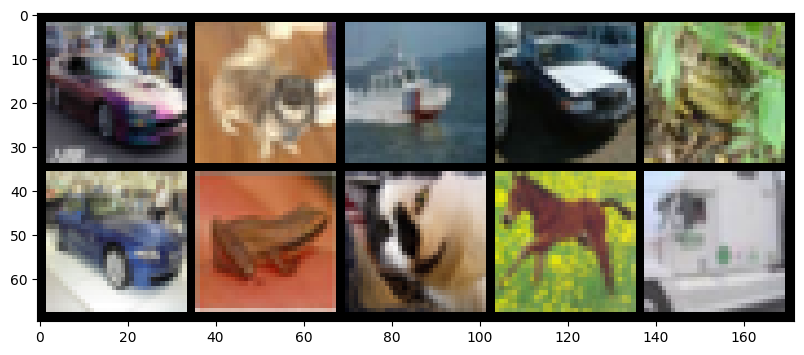

In [22]:
#print the images
im = make_grid(images,nrow=5)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [23]:
class ConvolutionalNetwork(nn.Module):

  def __init__(self):
    super().__init__()

    #convolutional layers

    self.conv1 = nn.Conv2d(3,6,5,1) #input_channel, output_channel(no. of kernals), kernal size=5x5, stride=1
    self.conv2 = nn.Conv2d(6,16,3,1)

    #fully connected layers
    self.fc1 = nn.Linear(6*6*16,120)
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,10)

    #forward Prop.
  def forward(self,X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X,2,2)

    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X,2,2)
    X = X.view(-1,6*6*16)
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X,dim=1)

In [24]:
torch.manual_seed(41)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [25]:
for param in model.parameters():
  print(param.numel()) #numel : no of elements

450
6
864
16
69120
120
10080
84
840
10


In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [27]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1

        # Apply the model
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%1000 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/50000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch: 1000 [ 10000/50000]  loss: 1.95038009  accuracy:  22.700%
epoch:  0  batch: 2000 [ 20000/50000]  loss: 1.79842687  accuracy:  29.365%
epoch:  0  batch: 3000 [ 30000/50000]  loss: 1.08747518  accuracy:  33.667%
epoch:  0  batch: 4000 [ 40000/50000]  loss: 1.07857060  accuracy:  36.222%
epoch:  0  batch: 5000 [ 50000/50000]  loss: 1.32883143  accuracy:  38.098%
epoch:  1  batch: 1000 [ 10000/50000]  loss: 1.29721260  accuracy:  47.800%
epoch:  1  batch: 2000 [ 20000/50000]  loss: 1.24478531  accuracy:  48.075%
epoch:  1  batch: 3000 [ 30000/50000]  loss: 1.95184422  accuracy:  48.517%
epoch:  1  batch: 4000 [ 40000/50000]  loss: 1.38563871  accuracy:  49.025%
epoch:  1  batch: 5000 [ 50000/50000]  loss: 1.63176787  accuracy:  49.448%
epoch:  2  batch: 1000 [ 10000/50000]  loss: 0.93672621  accuracy:  52.640%
epoch:  2  batch: 2000 [ 20000/50000]  loss: 1.49132168  accuracy:  52.900%
epoch:  2  batch: 3000 [ 30000/50000]  loss: 0.90392780  accuracy:  52.963%
epoch:  2  b

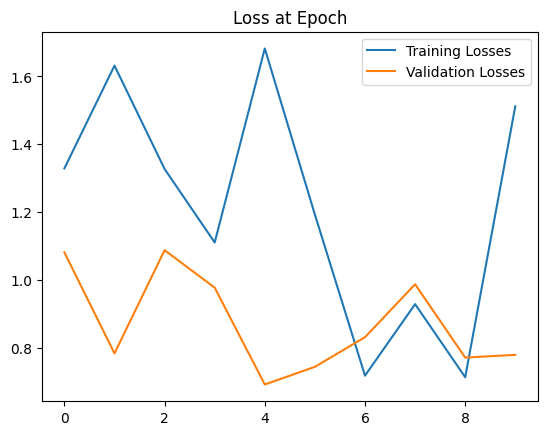

In [29]:
#Graph the loss at each epoch
train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses, label='Training Losses')
plt.plot(test_losses, label='Validation Losses')
plt.title('Loss at Epoch')
plt.legend()

Text(0.5, 1.0, 'Accuracy at the end of each epoch ')

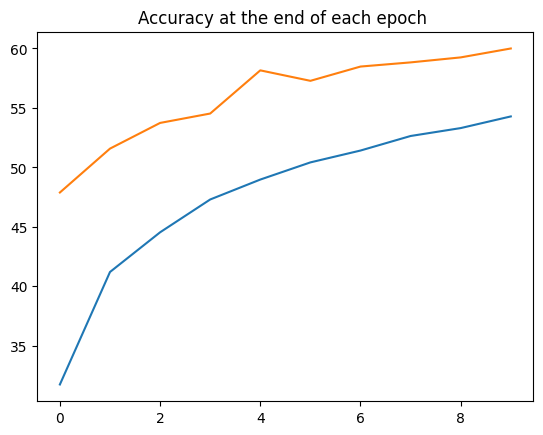

In [30]:
#graph the accuracy at the and of each epoch
plt.plot([t/600 for t in train_correct],label = 'training Accuracy')
plt.plot([t/100 for t in test_correct],label='Validation Accuracy')
plt.title('Accuracy at the end of each epoch ')

In [31]:
print(test_correct)

[tensor(4789), tensor(5158), tensor(5374), tensor(5453), tensor(5816), tensor(5728), tensor(5848), tensor(5883), tensor(5925), tensor(6000)]


In [32]:
num_c = test_correct[-1].item()*100

In [33]:
num_c

600000

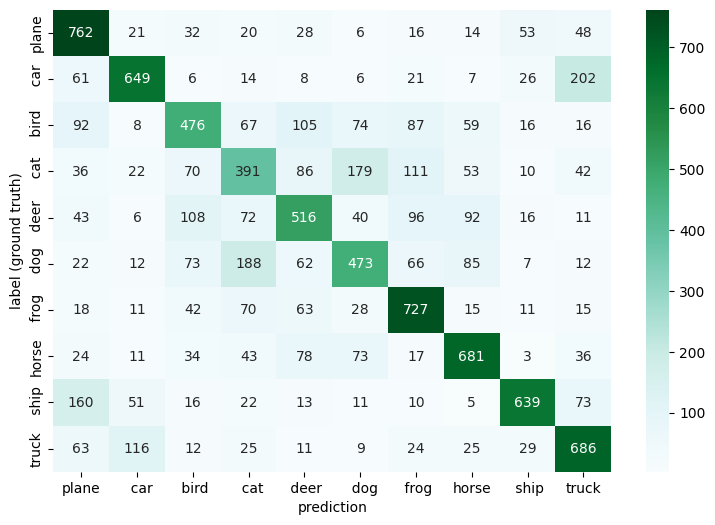

In [34]:
# Create a loader for the entire the test set
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

In [35]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')

# Display the number of misses
len(misses)

4000